<a href="https://colab.research.google.com/github/MariaBertolin/lineartanimdata/blob/main/lineartanimdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. SETUP ENVIRONMENT

NOTE: Select CANCEL when asked to restart session

In [ ]:
#lineartanimdata repo, without sketchkeras
%cd /content
!rm -rf *
!git clone https://github.com/MariaBertolin/lineartanimdata.git

In [ ]:
%cd lineartanimdata
#setup SAM2
%cd sam2
!bash script/install.sh
!pip install -e .
%cd checkpoints
!./download_ckpts.sh
%cd ../..
#install other libraries
!pip install matplotlib==3.9.2
!pip install opencv-python==3.4.17.61
!pip install "numpy<1.24"
#sketchKeras
!mkdir weights
%cd weights
!gdown 1Zo88NmWoAitO7DnyBrRhKXPcHyMAZS97
%cd ..

# 2. SETUP SCENE

Each scene has a folder with name <scene> within data/scenes containing the input video there, named footage.mp4.

A scene named "test" already exist to enable doing a fast test.

In [22]:
#The name of the scene (change it if you want to upload your own video)
# NO CAL FER SEGMENTACIÓ AMB LA PROVA, JA INCORPORA ELS FITXERS EXTRETS PER SAM2
# (per facilitar les proves de l'alternativa al sketchkeras)
scene = "ruben_sketch"

## (OPTIONAL) UPLOAD YOUR OWN VIDEO

*(You can skip the following code block to run a fast demo.)*

You can create a new scene by uploading a video from your computer. A new folder fill be created within data/scenes with the video there, renamed to footage.mp4.

In [8]:
#Run this code block to upload an input video from your computer
scene = "simpsons"
import io
import pandas as pd
from google.colab import files
print("Choose a video file from your computer.")
uploaded = files.upload()
video_file=[key for key in uploaded.keys()][0]
!mkdir ./data/scenes/{scene}
!cp "{video_file}" data/scenes/{scene}/footage.mp4

Choose a video file from your computer.


IndexError: list index out of range

# 3. SPLIT THE VIDEO INTO FRAMES



In [4]:
!rm -rf ./data/scenes/{scene}/imagesFull
!mkdir ./data/scenes/{scene}/imagesFull
!./subsample.sh /content/lineartanimdata/data/scenes/{scene} 0

mkdir: cannot create directory ‘imagesFull’: File exists
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --en

Check the first frame:

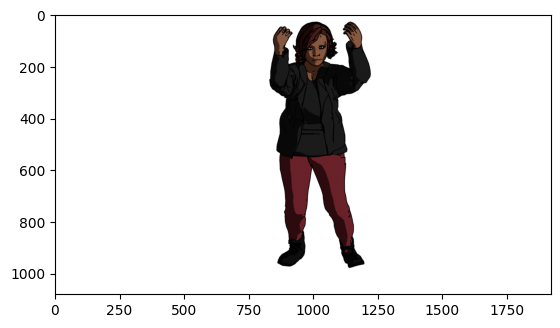

In [49]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
image_path = 'data/scenes/'+scene+'/imagesFull/001.jpg'
image = Image.open(image_path)  # Uncomment this line if using PIL

preproc_image = cv2.imread(image_path)
# Smoothening filter, removes noise sharpens edges. Test to see if there's a visible effect. Further tests on local!!
# smoothed_image = cv2.bilateralFilter(preproc_image,9,150,150)

plt.imshow(image)
plt.show()
# plt.imshow(smoothed_image)
# plt.show()

# 4. SEGMENTATION

## Find proper positive and negative coordinates for the mask (for the first frame)

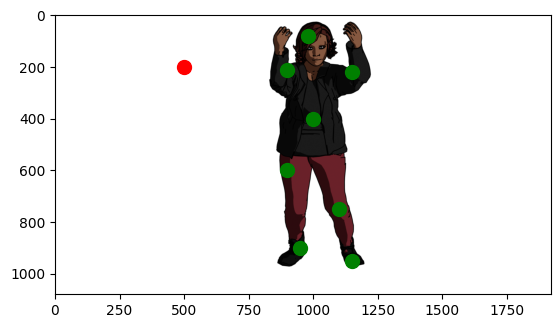

In [73]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np

masks_points = []
mask0_points = []
mask0_labels = []

#positive points
mask0_points.append([1000,400])
mask0_labels.append(1)

mask0_points.append([980,80]) #apple 1
mask0_labels.append(1)

mask0_points.append([900,600]) #apple 2
mask0_labels.append(1)

mask0_points.append([1100,750]) #apple 3
mask0_labels.append(1)

mask0_points.append([900,210]) #apple 4
mask0_labels.append(1)

mask0_points.append([1150,220]) #apple 5
mask0_labels.append(1)

mask0_points.append([950,900]) #apple 5
mask0_labels.append(1)

mask0_points.append([1150,950]) #apple 5
mask0_labels.append(1)

#negative points
mask0_points.append([500,200]) #example negative point (not necessary here)
mask0_labels.append(0)

masks_points.append([np.array(mask0_points, dtype=np.float32), np.array(mask0_labels, np.int32)])


image_path = 'data/scenes/'+scene+'/imagesFull/001.jpg'
image = Image.open(image_path)  # Uncomment this line if using PIL
plt.imshow(image)
for mask_points in masks_points:
        points = mask_points[0]
        labels = mask_points[1]

        i = 0
        for point in points:
            color = "green"
            if (labels[i]==0):
              color = "red"
            plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor=color, markerfacecolor=color)
            i=i+1
plt.show()

## Segment the first frame to test the coordinates

Setup the model (just do it the first time)

In [74]:
import cv2
import torch
import base64

import numpy as np

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = "/content/lineartanimdata/sam2/checkpoints/sam2.1_hiera_large.pt"
CONFIG = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(CONFIG, CHECKPOINT, device=DEVICE, apply_postprocessing=False)
#predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

mask_generator = SAM2AutomaticMaskGenerator(sam2_model)

Segment the first frame

In [75]:
IMAGE_PATH = 'data/scenes/'+scene+'/imagesFull/001.jpg'

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

smoothed_image_1 = cv2.bilateralFilter(image_rgb,9,150,150) # Smoothening filter, removes noise sharpens edges, discarded because didn't improve the results
smoothed_image_2 = cv2.GaussianBlur(image_rgb,(5,5),0) # Smoothening filter, removes noise sharpens edges, discarded because didn't improve the results
smoothed_image_3 = cv2.medianBlur(image_rgb,5)
#sam2_result = mask_generator.generate(image_rgb)

predictor = SAM2ImagePredictor(sam2_model)
predictor.set_image(image_rgb) # podria ser bgr
masks, scores, logits = predictor.predict(
    point_coords=points,
    point_labels=labels,
    multimask_output=False,
)

See results. Change points if results not satisfactory.

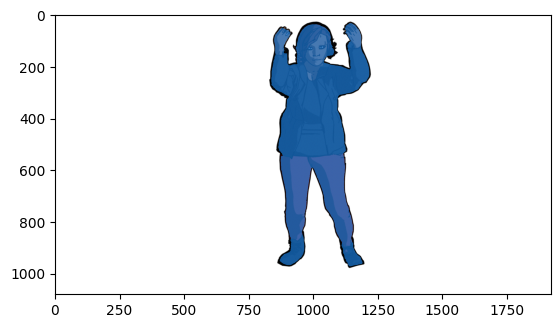

In [76]:
import matplotlib.pyplot as plt
import cv2
from PIL import Image
plt.imshow(image)

mask=masks[0]
color = np.array([30/255, 144/255, 255/255, 0.6])
h, w = mask.shape[-2:]
mask = mask.astype(np.uint8)
mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
plt.gca().imshow(mask_image)

#show_anns(masks[0])
plt.show()

## Segment all the video

In [77]:
import os
from sam2.build_sam import build_sam2_video_predictor

def RGB_to_opencv(c):
    return c[::-1]

#COLOR PALETTE (from segment.py from lester-code)
np.random.seed(200)
_palette = ((np.random.random((3*255))*0.7+0.3)*255).astype(np.uint8).tolist()
_palette = [0,0,0]+_palette
#c = _palette[id*3:id*3+3] USAGE

#Build our own dictionary for the colors
palette = {}
for i in range(255):
    palette[i] = _palette[i*3:i*3+3]


sam2_checkpoint = "sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

scene_path = "data/scenes/"+scene


#load frames
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = scene_path+"/imagesFull"
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

#initialize inference state
inference_state = predictor.init_state(video_path=video_dir)

ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 0  # give a unique id to each object we interact with (it can be any integers)

for mask_points in masks_points:
    print("add_new_points_or_box for ann_obj_id="+str(ann_obj_id))
    print(mask_points[0])
    points = mask_points[0]
    labels = mask_points[1]
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    ann_obj_id = ann_obj_id+1;


#PROPAGATION STAGE
output_path = scene_path+"/samtrack"
if not os.path.exists(output_path):
    os.makedirs(output_path)

#obtain dimensions of the image
first_frame = cv2.imread(os.path.join(video_dir, frame_names[0]))
height, width, channels = first_frame.shape

#Propagate the prompts to get the masklet across the video
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    print("frame done")
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }
    blank_image_BGR = np.zeros((height,width,3), np.uint8)
    blank_image_BGR[:] = 255
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        print("showing out_frame_idx="+str(out_frame_idx)+"/out_obj_id="+str(out_obj_id))
        mask = out_mask
        color = np.array([30/255, 144/255, 255/255, 0.6])
        h, w = mask.shape[-2:]
        mask = mask.astype(np.uint8)
        mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)

        #mask is a vector of 0s and 1s.
        #reshaping it as a matrix becomes a mask useful in opencv
        binary_mask = mask.reshape(h,w)

        #create a white blank image (3 channels)
        #blank_image_BGR = np.zeros((h,w,3), np.uint8)
        #blank_image_BGR[:] = 255

        #apply a color using the mask
        blank_image_BGR[binary_mask==1]=RGB_to_opencv(palette[(out_obj_id+10*1)%256])

    #save
    #cv2.imwrite(output_path+"/f"+str(out_frame_idx)+".png", blank_image_BGR)
    frame_filename_no_extension = os.path.splitext(frame_names[out_frame_idx])[0]
    cv2.imwrite(output_path+"/"+frame_filename_no_extension+'.png', blank_image_BGR)



frame loading (JPEG): 100%|██████████| 4/4 [00:00<00:00, 11.03it/s]


add_new_points_or_box for ann_obj_id=0
[[1000.  400.]
 [ 980.   80.]
 [ 900.  600.]
 [1100.  750.]
 [ 900.  210.]
 [1150.  220.]
 [ 950.  900.]
 [1150.  950.]
 [ 500.  200.]]


/content/lineartanimdata/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/content/lineartanimdata/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video:   0%|          | 0/4 [00:00<?, ?it/s]

frame done
showing out_frame_idx=0/out_obj_id=0


propagate in video:  50%|█████     | 2/4 [00:01<00:01,  1.70it/s]

frame done
showing out_frame_idx=1/out_obj_id=0


propagate in video:  75%|███████▌  | 3/4 [00:02<00:00,  1.25it/s]

frame done
showing out_frame_idx=2/out_obj_id=0


propagate in video: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]

frame done
showing out_frame_idx=3/out_obj_id=0


# 5. OTHER STEPS

In [2]:
!python step2_foreground.py data/scenes/{scene}
!python step3_cluster_color.py data/scenes/{scene}

process(data/scenes/simpsons_sketch/samtrack/001.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/002.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/003.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/004.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/005.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/006.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/007.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/008.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/009.png, data/scenes/simpsons_sketch/out_foreground/)
process(data/scenes/simpsons_sketch/samtrack/010.png, data/scenes/simpsons_sketch/out_foreground/)
process(da

In [19]:
!python src/maria_1.py --input data/scenes/{scene}/
!python step5_overlap_sketch.py data/scenes/{scene}/

process(data/scenes/ruben/out_clustercolor/01_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/05_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/13_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/15_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/16_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/36_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/37_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/38_img_CELSHADER_COL.png, data/scenes/ruben/out_sketch_fromclustercolor)
process(data/scenes/ruben/out_clustercolor/56_img_CELSHADER_COL.png, dat

In [23]:
!python src/ruben.py --input data/scenes/{scene}/
!python step5_overlap_sketch.py data/scenes/{scene}/

weights/model.pth loaded..
process(data/scenes/ruben_sketch//out_clustercolor/01_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clustercolor/05_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clustercolor/13_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clustercolor/15_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clustercolor/16_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clustercolor/36_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clustercolor/37_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_sketch_fromclustercolor/)
process(data/scenes/ruben_sketch//out_clus

c:\Users\maria\Desktop\TFG\Codi\lineartanimdata\src\ruben.py:27: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  highpass = highpass.astype(np.float) / 128.0
c:\Users\maria\Desktop\TFG\Codi\lineartanimdata\src\ruben.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.zeros((512, 512, 3), dtype=np.float)


process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/01_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/05_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/13_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/15_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/16_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/36_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromclustercolor/37_img_CELSHADER_COL.png, data/scenes/ruben_sketch//out_overlap_sketch/)
process(data/scenes/ruben_sketch//out_sketch_fromcluste

#6. CHECK RESULTS

In [ ]:
from IPython.display import Image
Image('data/scenes/'+scene+'/out_overlap_sketch/0001.png')

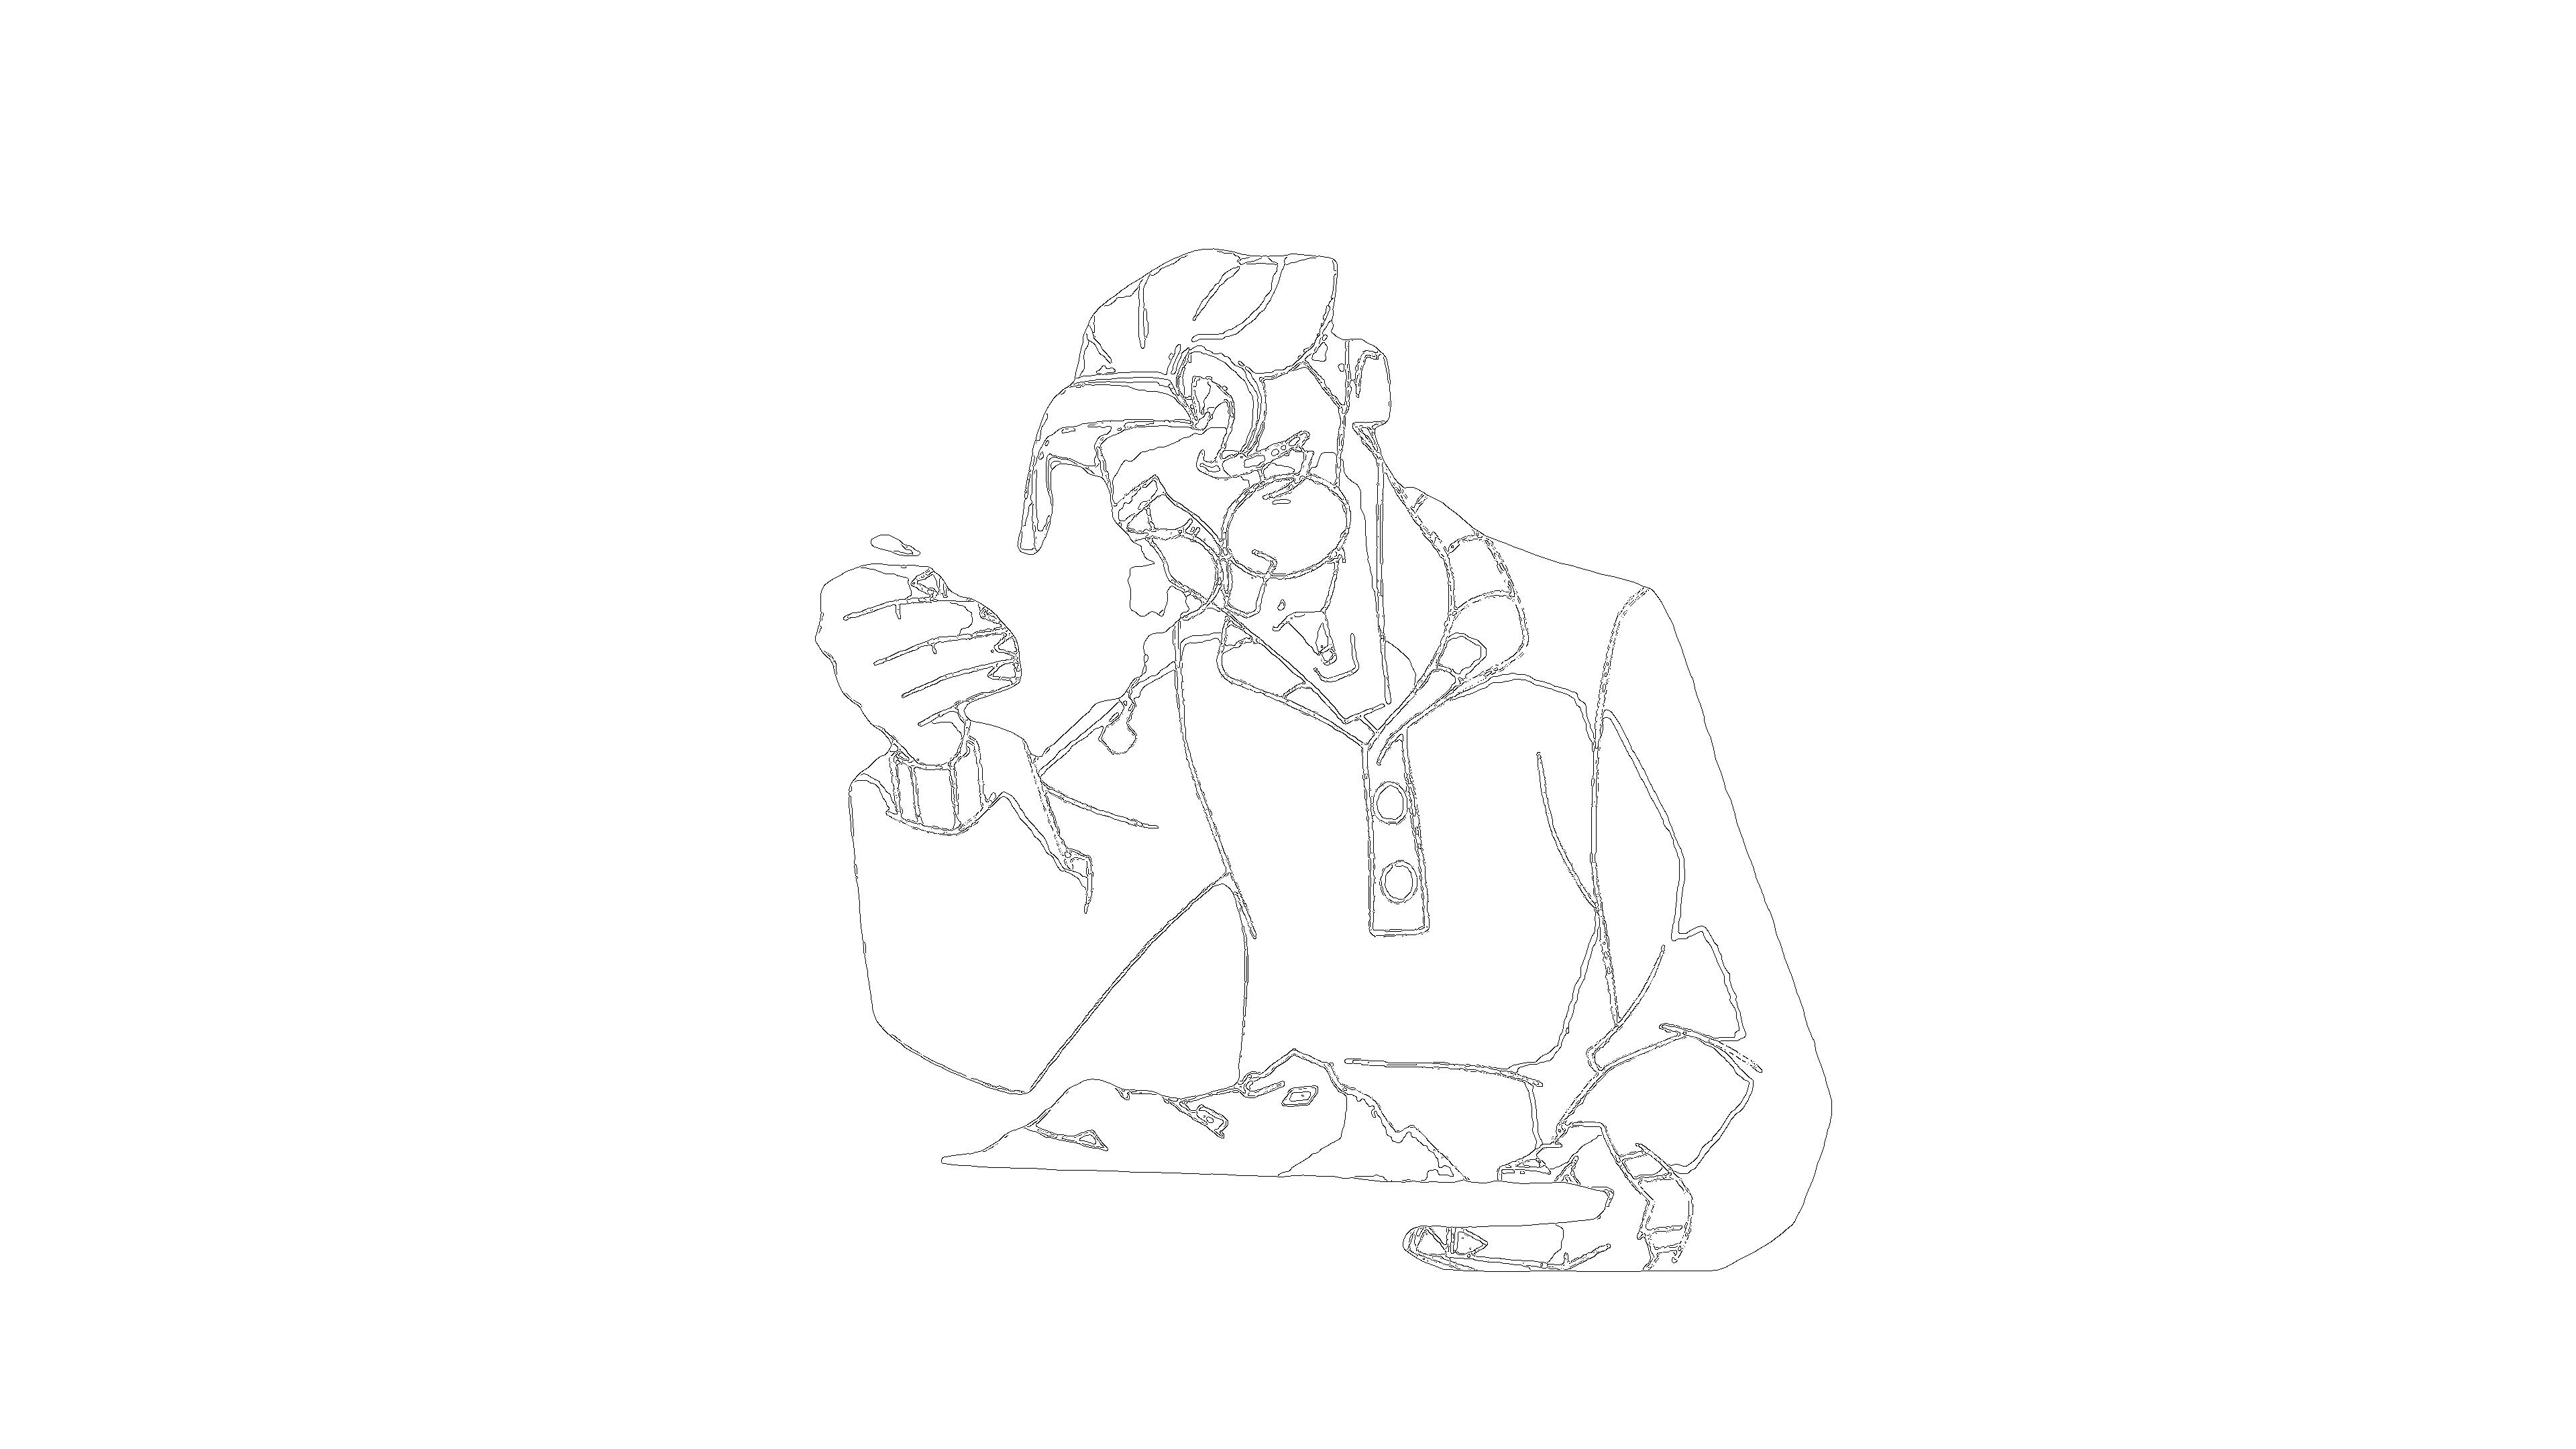

In [73]:
Image('data/scenes/'+scene+'/out_overlap_sketchalpha/004.png')

# 7. DOWNLOAD RESULTS

In [ ]:
!rm -f scene+"_color.zip"
#Download the color+lineart frames
!zip -r -qq {scene}_color.zip data/scenes/{scene}/out_overlap_sketch/
from google.colab import files
files.download(scene+"_gt.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [83]:
!rm -f scene+"_lineart.zip"
#Download the lineart frames
!zip -r -qq {scene}_lineart.zip data/scenes/{scene}/out_overlap_sketchalpha/
from google.colab import files
files.download(scene+"_lines.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
!rm -f scene+"_all.zip"
#Download all, including intermediate results (slow)
!zip -r -qq {scene}_all.zip data/scenes/{scene}/
from google.colab import files
files.download(scene+"_all.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import os
import shutil

def copy_and_rename_images(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_files = sorted([f for f in os.listdir(input_path) if f.endswith(".png")])
    
    for i, filename in enumerate(image_files):
        source = os.path.join(input_path, filename)
        new_name = f"{i:04d}.png"
        destination = os.path.join(output_path, new_name)

        shutil.copyfile(source, destination)
        print(f"Copied: {source} -> {destination}")

In [24]:
# Copy from out_overlap_sketch to gt
scene = "ruben_sketch"
scene_out = "ruben_sketch"
#C:\Users\maria\Desktop\TFG\Codi\lineartanimdata\data\scenes\prova
copy_and_rename_images(f"./data/scenes/{scene}/out_overlap_sketch", f"{scene_out}/gt")

# Copy from out_overlap_sketchalpha to line
copy_and_rename_images(f"./data/scenes/{scene}/out_overlap_sketchalpha", f"{scene_out}/line")

Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\01_img_CELSHADER_COL.png -> ruben_sketch/gt\0000.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\05_img_CELSHADER_COL.png -> ruben_sketch/gt\0001.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\13_img_CELSHADER_COL.png -> ruben_sketch/gt\0002.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\15_img_CELSHADER_COL.png -> ruben_sketch/gt\0003.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\16_img_CELSHADER_COL.png -> ruben_sketch/gt\0004.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\36_img_CELSHADER_COL.png -> ruben_sketch/gt\0005.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\37_img_CELSHADER_COL.png -> ruben_sketch/gt\0006.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\38_img_CELSHADER_COL.png -> ruben_sketch/gt\0007.png
Copied: ./data/scenes/ruben_sketch/out_overlap_sketch\56_img_CELSHADER_COL.png -> ruben_sketch/gt\0008.png
Copied: ./data/scenes/ruben_sketch/ou